# Part A

### 1. Project environment & packages

In [1]:
using Pkg
Pkg.activate("..")

using DrWatson
@quickactivate "FE2P1SvobodaVlach"

  Activating project at `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach`


In [2]:
using MarketData
using Dates
using DataFrames
using StatsPlots
using ARCHModels

### 2. Download data for Apple

In [3]:
ticker = "AAPL"

start_date = DateTime(2023, 1, 1)
stop_date = DateTime(2024, 1, 1)

2024-01-01T00:00:00

In [4]:
data_apple = DataFrame(yahoo(ticker, YahooOpt(period1 = start_date, period2 = stop_date)));

### 3. Summary statistics & plots

In [5]:
first(data_apple, 3)

Row,timestamp,Open,High,Low,Close,AdjClose,Volume
,Date,Float64,Float64,Float64,Float64,Float64,Float64
1,2023-01-03,130.28,130.9,124.17,125.07,123.905,1.12118e8
2,2023-01-04,126.89,128.66,125.08,126.36,125.183,8.91136e7
3,2023-01-05,127.13,127.77,124.76,125.02,123.855,8.09627e7


In [6]:
typeof(data_apple)

DataFrame

In [7]:
size(data_apple)

(250, 7)

In [8]:
plot(data_apple.timestamp, data_apple.AdjClose, 
    line=(1.5, 0.7, :solid), size=(800,300), palette=:seaborn_colorblind,
    label="AdjClose", xlabel="Time", ylabel="AdjClose") # Proc se nevejdou axis labels??

savefig(plotsdir("apple_adjclose.png")) # Save to "plots/"

"/Users/tomassvoboda/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/plots/apple_adjclose.png"

In [9]:
summary_stats = describe(data_apple[:, :AdjClose])

Summary Stats:
Length:         250
Missing Count:  0
Mean:           171.470440
Std. Deviation: 17.437953
Minimum:        123.855087
1st Quartile:   160.847187
Median:         174.581657
3rd Quartile:   186.470264
Maximum:        197.361084
Type:           Float64


### 4. Model & forecast

In [10]:
# Parameters
pred_length = 10 # Number of predictions

10

In [11]:
# Log-returns
ret_apple = DataFrame(
    returns = diff(log.(data_apple[:, :AdjClose])),
    timestamp = data_apple.timestamp[2:end]
)

plot(ret_apple.timestamp, ret_apple.returns,
    line=(1, 0.7), size=(800,300),
    xlabel="Time", ylabel="Log Returns",
    title="Apple Log-Returns", label="Log-returns"
)

savefig(plotsdir("apple_logreturns.png")) # Save to "plots/"

"/Users/tomassvoboda/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/plots/apple_logreturns.png"

In [12]:
# Autocoorelation function -> used on prices or returns???
plot(autocor(ret_apple.returns, 1:20),
    seriestype=:bar, 
    xlabel="Lag", 
    ylabel="Autocorrelation", 
    title="Autocorrelation Function for Apple Returns")

savefig(plotsdir("apple_autocor.png")) # Save to "plots/"

"/Users/tomassvoboda/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/plots/apple_autocor.png"

In [13]:
# Train-test split
train_apple = ret_apple[1:end-pred_length, :]
test_apple = ret_apple[end-pred_length+1:end, :]

Row,returns,timestamp
,Float64,Date
1,-0.00272943,2023-12-15
2,-0.00853965,2023-12-18
3,0.00534578,2023-12-19
4,-0.0107717,2023-12-20
5,-0.000770337,2023-12-21
6,-0.00556283,2023-12-22
7,-0.00284507,2023-12-26
8,0.00051788,2023-12-27
9,0.00222378,2023-12-28


In [22]:
# Fit
garch_fit = fit(GARCH{1,1}, train_apple.returns)


GARCH{1, 1} model with Gaussian errors, T=239.

Mean equation parameters:
────────────────────────────────────────────
    Estimate    Std.Error  z value  Pr(>|z|)
────────────────────────────────────────────
μ  0.0019609  0.000832063  2.35668    0.0184
────────────────────────────────────────────

Volatility parameters:
──────────────────────────────────────────────
      Estimate   Std.Error   z value  Pr(>|z|)
──────────────────────────────────────────────
ω   8.97307e-6  1.86881e-5  0.480149    0.6311
β₁  0.936011    0.128388    7.29049     <1e-12
α₁  0.00649429  0.031428    0.20664     0.8363
──────────────────────────────────────────────


In [30]:
garch_pred = predict.(garch_fit, :return, 1:pred_length)

10-element Vector{Float64}:
 0.0019609045012429814
 0.0019609045012429814
 0.0019609045012429814
 0.0019609045012429814
 0.0019609045012429814
 0.0019609045012429814
 0.0019609045012429814
 0.0019609045012429814
 0.0019609045012429814
 0.0019609045012429814

### 5. Forecasts plot

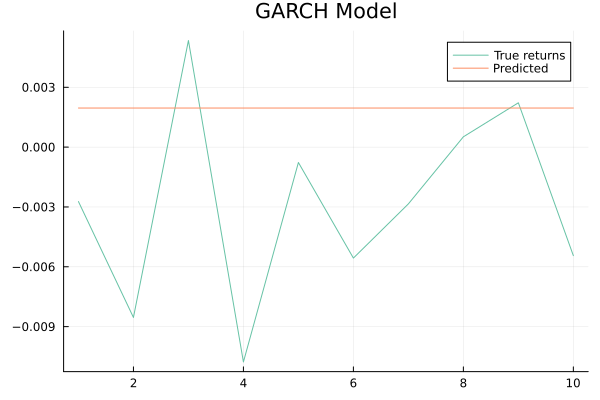

In [31]:
p1 = plot(test_apple.returns, lab="True returns", leg=:topright, title="GARCH Model", palette=:Set2_3)
p1 = plot!(garch_pred, lab="Predicted")

# Part B